In [212]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
# import category_encoders as ce
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor
import random
import pandas as pd

In [213]:
data_dir = '/content/drive/My Drive/data/predictBookprices'

In [214]:
df = pd.read_csv(data_dir + '/Data_Train.csv', encoding='cp1252')

In [215]:
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [216]:
df.shape

(6237, 9)

In [217]:
df.isna().sum()

Title           0
Author          0
Edition         0
Reviews         0
Ratings         0
Synopsis        0
Genre           0
BookCategory    0
Price           0
dtype: int64

In [218]:
def prepare_data(df):
    ''' cleaning data - fields Reviews, Ratings and Edtition'''
    
    df['Ratings'] = df.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')
    df['Reviews'] = df.Reviews.str.split().str.get(0).astype('float')
    df['Edition_type'] = df.Edition.str.split(',').str.get(0)
    df['Edition_year'] = df.Edition.str.split().str.get(-1)
    df = df.drop(columns=['Edition'])
    return df

In [219]:
df = prepare_data(df)
# df.to_csv("Data/new_data.csv", index=None)
# data = pd.read_csv("Data/new_data.csv")
df.head()


,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,2012
2,Leviathan (Penguin Classics),Thomas Hobbes,4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,2006


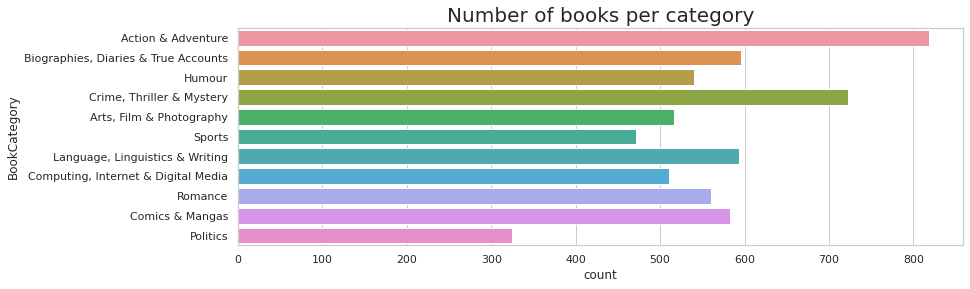

In [220]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="BookCategory", data=df).set_title("Number of books per category",fontsize=20)
plt.show()

In [221]:
data = df

Text(0.5, 1.0, 'Price of Books vs reviews')

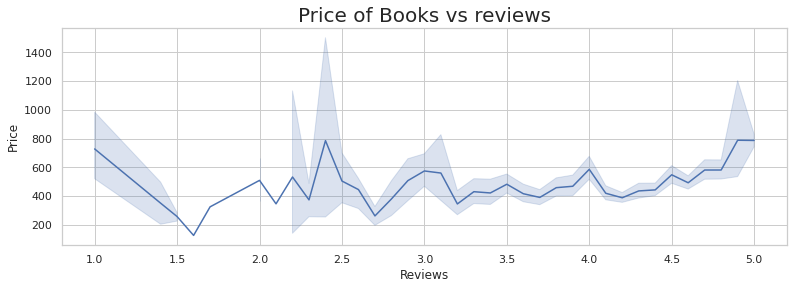

In [222]:
plt.figure(figsize=(13, 4))
sns.lineplot(x="Reviews", y="Price", data=data).set_title("Price of Books vs reviews",fontsize=20)

Text(0.5, 1.0, 'Price of Books vs No. of Ratings')

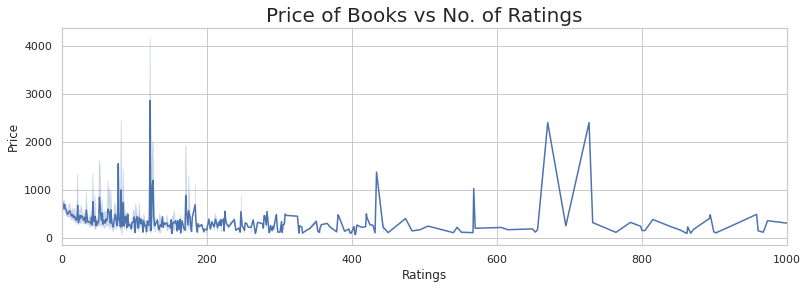

In [223]:
plt.figure(figsize=(13, 4))
ax = sns.lineplot(x="Ratings", y="Price", data=data)
ax.set_xlim([0,1000])
ax.set_title("Price of Books vs No. of Ratings",fontsize=20)

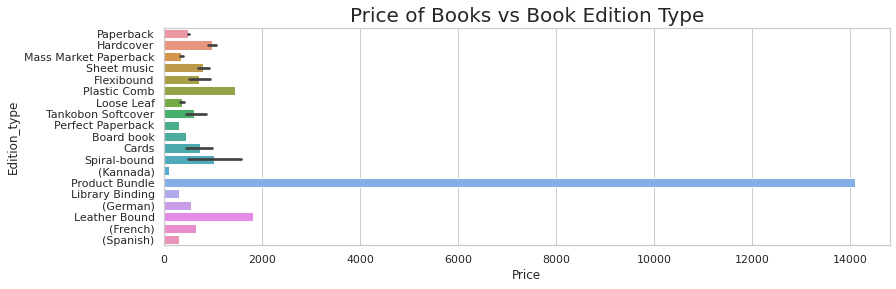

In [224]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.barplot(x="Price", y="Edition_type", data=data).set_title("Price of Books vs Book Edition Type",fontsize=20)
plt.show()

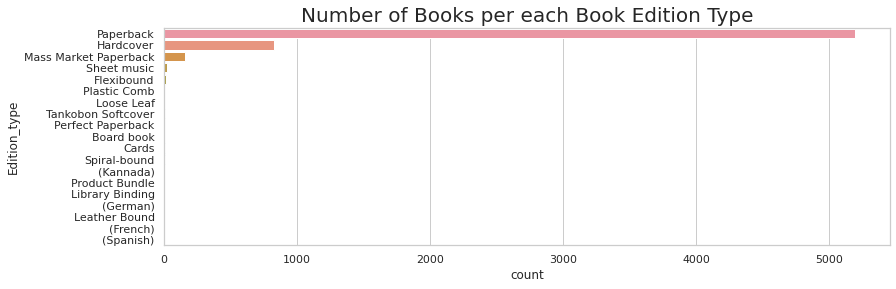

In [225]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="Edition_type", data=data).set_title("Number of Books per each Book Edition Type",fontsize=20)
plt.show()

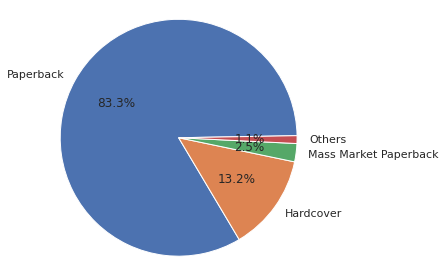

In [226]:
x = dict(data['Edition_type'].value_counts())
total = 0
for i, j in x.items():
    if j <= 24:
        total+=j
keys = [i for i, j in x.items() if j > 24]
keys.append("Others")
values = [j for i, j in x.items() if j > 24]
values.append(total)
labels = keys
sizes = values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [227]:
counts = pd.value_counts(data['Edition_type'])
mask = data['Edition_type'].isin(counts[counts > 24].index)
data['Edition_type'][~mask] = "Other_editions"

In [228]:
data['Edition_type'].value_counts()

Paperback                5193
Hardcover                 823
Mass Market Paperback     155
Other_editions             66
Name: Edition_type, dtype: int64

In [229]:
counts = pd.value_counts(data['Genre'])
mask = data['Genre'].isin(counts[counts > 7].index)
data['Genre'][~mask] = "Other_genres"

In [230]:
counts = pd.value_counts(data['Author'])
mask = data['Author'].isin(counts[counts > 2].index)
data['Author'][~mask] = "Other_authors"

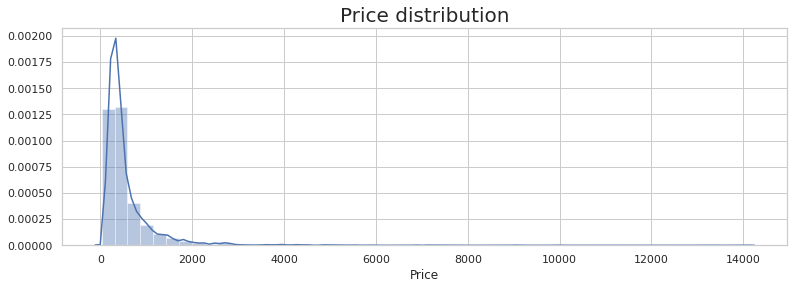

In [231]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution", fontsize=20)
plt.show()

In [232]:
import re
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    # text = text.split()

    return text

In [233]:
import string
data['Synopsis'] = data['Synopsis'].apply(text_to_word_list)
data["num_words_synops"] = data["Synopsis"].apply(lambda x: len(str(x).split()))
## Number of characters in the Synopsis ##
data["num_chars_synops"] = data["Synopsis"].apply(lambda x: len(str(x)))

## Number of punctuations in the Synopsis ##
data["num_punct_synops"] = data['Synopsis'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
data["num_words_title"] = data["Title"].apply(lambda x: len(str(x).split()))
data["mean_word_len"] = data["Synopsis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [234]:
data['Title'] = data['Title'].apply(text_to_word_list)

Text(0.5, 1.0, 'Cheaper Books : Top words in titles')

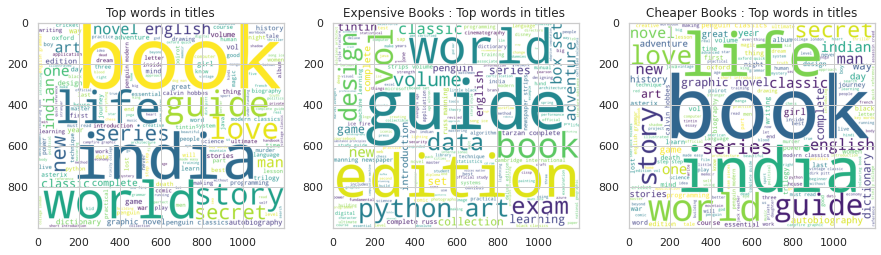

In [235]:
from wordcloud import WordCloud, STOPWORDS
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 15)
text = ' '.join(data['Title'].values)
wordcloud1 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
data2 = data[data['Price'] >= 1500]
text = ' '.join(data2['Title'].values)
wordcloud2 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
# plt.imshow(wordcloud)
data2 = data[data['Price'] < 1500]
text = ' '.join(data2['Title'].values)
wordcloud3 = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
ax[0].imshow(wordcloud1)
ax[1].imshow(wordcloud2)
ax[2].imshow(wordcloud3)
ax[0].set_title("Top words in titles")
ax[1].set_title("Expensive Books : Top words in titles ")
ax[2].set_title("Cheaper Books : Top words in titles")


In [236]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
data['Title_clean'] = data['Title'].str.split().apply(lambda x: " ".join([item for item in x if item not in stop]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [237]:
data[data['Price'] > 1500].Title_clean.str.split(expand=True).stack().value_counts()[:20]

:           183
-            86
guide        36
edition      27
complete     24
set          23
1            22
world        17
volume       17
learning     17
python       14
2            14
art          13
design       13
data         12
classics     11
box          11
4            11
vol          11
exam         10
dtype: int64

In [238]:
data[data['Price'] < 1500].Title_clean.str.split(expand=True).stack().value_counts()[:20]

:           2661
-            744
book         392
1            262
guide        200
english      179
india        177
classics     177
edition      174
series       168
2            168
world        161
life         142
story        136
vol          135
3            133
novel        124
one          124
man          118
penguin      117
dtype: int64

# Since words in title seem to see some correlation with the price of Books. We can use TFIDF features.

In [240]:
x = dict(data.Title_clean.str.split(expand=True).stack().value_counts())
x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}

In [241]:
total_words = [key for key, value in x.items() if len(key) > 1]
len(total_words)

7474

In [242]:
total_words = [key for key, value in x.items() if len(key) > 1 and value > 10]
len(total_words)

571

In [243]:
corpus = list(df['Title_clean'])

In [244]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=total_words)
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['book', 'guide', 'edition', 'classics', 'english', 'india', 'series', 'world', 'life', 'vol', 'story', 'one', 'novel', 'penguin', 'man', 'complete', 'new', 'love', 'art', 'dictionary', 'graphic', 'adventures', 'oxford', 'indian', 'modern', 'stories', 'history', 'learning', 'data', 'volume', 'grammar', 'asterix', 'big', 'vintage', 'secret', 'novels', 'great', 'design', 'books', 'course', 'cd', 'autobiography', 'first', 'practice', 'easy', 'way', 'step', 'trilogy', 'girl', 'programming', 'game', 'science', 'tintin', 'learn', 'death', 'last', 'cambridge', 'words', 'journey', 'war', 'language', '2018', 'time', 'library', 'mind', 'fire', 'level', 'reference', 'grade', 'little', 'exam', 'black', 'piano', 'day', '10', 'night', 'made', 'key', 'best', 'power', 'things', 'lost', 'calvin', 'business', 'magic', 'red', 'short', 'hobbes', 'introduction', 'python', 'training', 'true', 'secrets', 'trinity', 'collection', 'theory', 'omnibus', 'know', 'music', 'jack', 'cricket', 'college', 'comics', 'i

In [245]:
tfidf_features = pd.DataFrame(data=X.todense(), columns=vectorizer.get_feature_names())
tfidf_features.shape

(6237, 571)

In [246]:
data = pd.concat([data, tfidf_features], axis=1)

In [183]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-07-23 19:43:59--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.226.75
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.226.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [48]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [139]:
stemmer = stem.PorterStemmer()
stop_words = stopwords.words('english')

def stem_stop(input_text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    # tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens

def get_mean_vector(word2vec_model, words):
    list_vec = []
    extra_vocab = {}
    for word in words:
        if word in word2vec_model.vocab:
            list_vec.append(word2vec_model[word])
        else:
            if word not in extra_vocab.keys():
                extra_vocab[word] = np.random.normal(0, 1, 300)
            list_vec.append(extra_vocab[word])
    if len(list_vec) == 0:
        list_vec.append(np.random.normal(0, 1, 300))
    list_vec = np.array(list_vec)
    return np.mean(list_vec, axis=0)

def get_word_vectors(df, word2vec):
    sentences_train = list(df)
    sentences_train = [stem_stop(i) for i in sentences_train]
    sentences_train = np.array([get_mean_vector(word2vec, i) for i in sentences_train])
    headers = ["TitileV"+ str(i) for i in range(300)]
    sentences_train = pd.DataFrame(data=sentences_train, columns=headers)
    return sentences_train


# model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)
word2vec_features = get_word_vectors(data['Title'], word2vec)
# headers = ["TitleV"+ str(i) for i in range(300)]
# sentences = pd.DataFrame(data=sentences , index=data.index, columns=headers)
# data = pd.concat([data, sentences], axis=1)

In [140]:
word2vec_features.shape, data.shape, word2vec_features.columns

((6237, 300),
 (6237, 16),
 Index(['TitileV0', 'TitileV1', 'TitileV2', 'TitileV3', 'TitileV4', 'TitileV5',
        'TitileV6', 'TitileV7', 'TitileV8', 'TitileV9',
        ...
        'TitileV290', 'TitileV291', 'TitileV292', 'TitileV293', 'TitileV294',
        'TitileV295', 'TitileV296', 'TitileV297', 'TitileV298', 'TitileV299'],
       dtype='object', length=300))

In [142]:
data = pd.concat([data, word2vec_features], axis=1)

In [247]:
data.shape

(6237, 587)

In [248]:
le = LabelEncoder()
le.fit(data['BookCategory'])
data['BookCategory'] = le.transform(data['BookCategory'])

In [249]:
leET = LabelEncoder()
leET.fit(data['Edition_type'])
data['Edition_type'] = leET.transform(data['Edition_type'])

In [250]:
leET = LabelEncoder()
leET.fit(data['Author'])
data['Author'] = leET.transform(data['Author'])

In [251]:
leET = LabelEncoder()
leET.fit(data['Genre'])
data['Genre'] = leET.transform(data['Genre'])

In [252]:
data.head()

,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year,num_words_synops,num_chars_synops,num_punct_synops,num_words_title,mean_word_len,Title_clean,book,guide,edition,classics,english,india,series,world,life,vol,story,one,novel,penguin,man,complete,new,love,art,dictionary,graphic,adventures,oxford,indian,...,spoken,silence,becoming,portrait,girls,coloring,china,sql,strike,diaries,sword,legends,creating,solving,quest,mountain,sport,john,wonder,emperor,ages,cards,screenwriting,winner,iron,information,cormoran,daughter,masters,think,stars,stage,core,matter,higher,island,league,bestselling,beginners,academia
0,the prisoner gold the hunters 3,52,4.0,8,the hunters return in their third brilliant no...,0,0,220.00,3,2016,133,767,1,6,4.766917,prisoner gold hunters 3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,guru dutt : a tragedy in three acts,248,3.9,14,a layered portrait of a troubled genius for wh...,21,2,202.93,3,2012,198,1133,5,7,4.722222,guru dutt : tragedy three acts,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,leviathan penguin classics,339,4.8,6,during the time men live without a common pow...,65,6,299.00,3,1982,263,1631,4,3,5.197719,leviathan penguin classics,0.0,0.0,0.0,0.679022,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.734117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a pocket full of rye miss marple,6,4.1,13,a handful of grain is found in the pocket of a...,32,5,180.00,3,2017,76,415,0,7,4.460526,pocket full rye miss marple,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,life 70 years of extraordinary photography,248,5.0,1,for seven decades life has been thrilling the ...,83,1,965.62,0,2006,106,640,1,6,5.037736,life 70 years extraordinary photography,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.37895,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
data_ = data.drop(columns=['Title', 'Synopsis'])
data.shape, data.columns

((6237, 587),
 Index(['Title', 'Author', 'Reviews', 'Ratings', 'Synopsis', 'Genre',
        'BookCategory', 'Price', 'Edition_type', 'Edition_year',
        ...
        'stars', 'stage', 'core', 'matter', 'higher', 'island', 'league',
        'bestselling', 'beginners', 'academia'],
       dtype='object', length=587))

Text(0.5, 1.0, 'Log of Price Distribution (gives Normalk Distr.)')

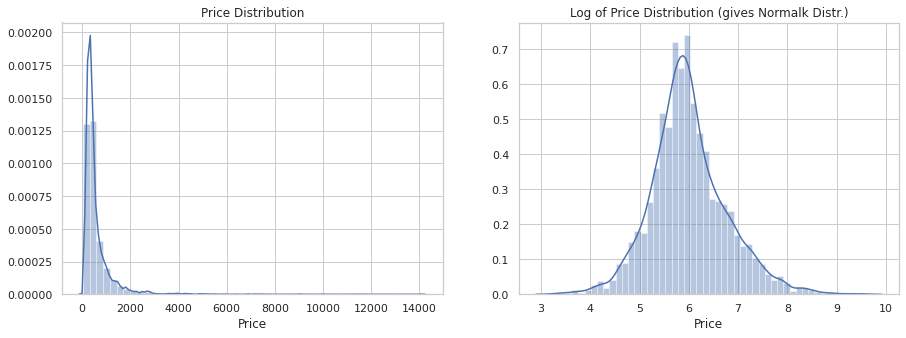

In [254]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 5)
sns.distplot(data['Price'], ax=ax[0])
sns.distplot(np.log1p(data['Price']), ax=ax[1])
ax[0].set_title("Price Distribution")
ax[1].set_title("Log of Price Distribution (gives Normalk Distr.)")
# ax[2].set_title("Cheaper Books : Top words in titles")

In [255]:
def normalize_data(data):
    x = data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df2 = pd.DataFrame(x_scaled)
    return df2

In [256]:
label = np.log1p(data['Price'])
final_data = data.drop(columns=['Price', 'Title', 'Synopsis', 'Edition_year', 'Title_clean'])
# final_data = normalize_data(final_data)

In [257]:
final_data.head()

,Author,Reviews,Ratings,Genre,BookCategory,Edition_type,num_words_synops,num_chars_synops,num_punct_synops,num_words_title,mean_word_len,book,guide,edition,classics,english,india,series,world,life,vol,story,one,novel,penguin,man,complete,new,love,art,dictionary,graphic,adventures,oxford,indian,modern,stories,history,learning,data,...,spoken,silence,becoming,portrait,girls,coloring,china,sql,strike,diaries,sword,legends,creating,solving,quest,mountain,sport,john,wonder,emperor,ages,cards,screenwriting,winner,iron,information,cormoran,daughter,masters,think,stars,stage,core,matter,higher,island,league,bestselling,beginners,academia
0,52,4.0,8,0,0,3,133,767,1,6,4.766917,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,248,3.9,14,21,2,3,198,1133,5,7,4.722222,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,339,4.8,6,65,6,3,263,1631,4,3,5.197719,0.0,0.0,0.0,0.679022,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.734117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,4.1,13,32,5,3,76,415,0,7,4.460526,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,248,5.0,1,83,1,0,106,640,1,6,5.037736,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.37895,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
x_train, x_test, y_train, y_test = train_test_split(final_data, label, test_size=0.10, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5613, 582), (624, 582), (5613,), (624,))

In [ ]:
mlp_reg = MLPRegressor(verbose=True, n_iter_no_change=100)
mlp_reg.fit(x_train, y_train)
y_pred = reg_model.predict(x_train)
print("Train : ", np.sqrt(np.square(y_pred - y_train).mean()))

predictions = list(reg_model.predict(x_test))
print("test : ", np.sqrt(np.square(predictions - y_test).mean()))

In [259]:
reg_model = DecisionTreeRegressor(max_depth=5)

reg_model.fit(x_train, y_train)

y_pred = reg_model.predict(x_train)
print("Train : ", np.sqrt(np.square(y_pred - y_train).mean()))

predictions = list(reg_model.predict(x_test))
print("test : ", np.sqrt(np.square(predictions - y_test).mean()))
# print("Test: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Train :  0.6483783077331563
test :  0.6761765398081145


In [260]:
import xgboost
# best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7,
#                  gamma=0,                 
#                  learning_rate=0.07,
#                  max_depth=4,
#                  min_child_weight=1.5,
#                  n_estimators=2000,                                                                    
#                  reg_alpha=0.85,
#                  reg_lambda=0.45,
#                  subsample=0.2,
#                  seed=42)
best_xgb_model = xgboost.XGBRegressor(max_depth= 3, learning_rate=0.07,
                                      n_estimators=1000)
best_xgb_model.fit(x_train,y_train)

y_pred = best_xgb_model.predict(x_train)
print("Train : ", np.sqrt(np.square(y_pred - y_train).mean()))

predictions = list(best_xgb_model.predict(x_test))
print("test : ", np.sqrt(np.square(predictions - y_test).mean()))

[20:06:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train :  0.442782349548423
test :  0.5684972722829797


In [265]:
x_train.shape

(5613, 582)

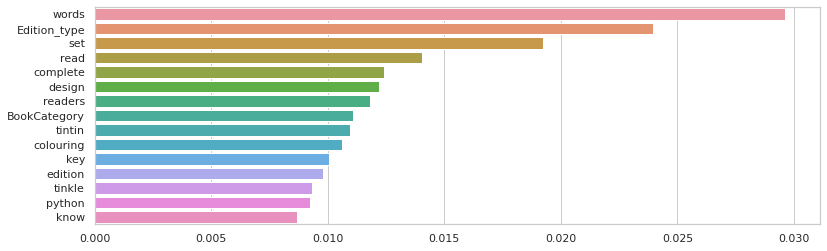

In [267]:
d = {}
for i in range(582):
    d[x_train.columns[i]] = best_xgb_model.feature_importances_[i]
import operator
plt.figure(figsize=(13, 4))
sorted_d = dict(sorted(d.items(), key=operator.itemgetter(1),reverse=True))
sns.barplot(x=list(sorted_d.values())[:15], y=list(sorted_d.keys())[:15])

In [276]:
y_test_ = list(y_test)
y_pred_ = list(predictions)
print(len(y_test_), len(y_pred_))
x = zip(y_test_, y_pred_)
zipped = list(x) 
res = sorted(zipped, key = lambda x: x[1])
y_test_ = [i[0] for i in res]
y_pred_ = [i[1] for i in res]

624 624


Text(0, 0.5, 'Price')

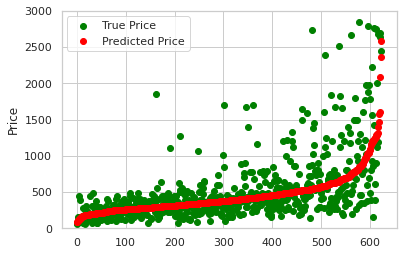

In [282]:
# sns.scatterplot(x=y_test, y="tip",)
# plt.subplot(1,3,1)
axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([0,3000])
plt.scatter(x = range(0, len(y_test_)), y = np.exp(y_test_), c="green")
plt.scatter(x= range(0, len(y_test_)), y= np.exp(y_pred_), c='red')
plt.legend(["True Price", "Predicted Price"])

plt.ylabel("Price")